<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-quantum-machine-learning/1_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Binary Classification

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, the Titanic sank after colliding with an iceberg. Being considered
unsinkable, there weren’t enough lifeboats for everyone on board.
As a result, 1502 out of 2224 passengers and crew members died that night.

Of course, the 722 survivors must have had some luck. But it seems as if certain
groups of people had better chances to survive than others. Therefore,
the Titanic sinking has also become a famous starting point for anyone interested
in machine learning.

The problem to be solved is simple. Use machine learning to create a model
that, given the passenger data, predicts which passengers survived the Titanic
shipwreck.

##Setup

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import matplotlib

Let's download titanic dataset from Kaggle.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [4]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/competitions/titanic
kaggle competitions download -c titanic

unzip -qq titanic.zip
rm -rf titanic.zip

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 28.7MB/s]


##Dataset

In [5]:
# load dataset
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# The shapes of the Titanic datasets
print("train has {} rows and {} columns".format(*train.shape))
print("test has {} rows and {} columns".format(*test.shape))

train has 891 rows and 12 columns
test has 418 rows and 11 columns


In [6]:
# The structure of the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
# The structure of the test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
# Look at the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##Data Preparation

Before we can feed our data into any machine learning algorithm, we need to
clean up.

###Missing Values

In [9]:
# option 1: We only have two passengers without it. This is bearable
train = train.dropna(subset=["Embarked"])

# option 2: We only have very few information about the cabin, let's drop it
train = train.drop("Cabin", axis=1)

# option 2: The age misses quite a few times. But intuition says it might be important for someone's chance to survive.
mean = train["Age"].mean()
train["Age"] = train["Age"].fillna(mean)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


###Identifiers

In [10]:
# Let’s have a look at how many unique values are
print(f"There are {train['PassengerId'].nunique()} PassengerIds in the data")
print(f"There are {train['Name'].nunique()} different (unique) names in the data")
print(f"There are {train['Ticket'].nunique()} different (unique) ticket numbers in the data")

There are 889 PassengerIds in the data
There are 889 different (unique) names in the data
There are 680 different (unique) ticket numbers in the data


In [11]:
# let's remove these identifying columns
train = train.drop("PassengerId", axis=1)
train = train.drop("Name", axis=1)
train = train.drop("Ticket", axis=1)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


###Categorical Attributes

In [12]:
label_encoder = LabelEncoder()

for col in ["Sex", "Embarked"]:
  label_encoder.fit(train[col])
  train[col] = label_encoder.transform(train[col])

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2


###Feature Scaling

In [13]:
# The maximum values
# check the maximum value in a column
print(f"The maximum age is {train['Age'].max()}")
print(f"The maximum fare is {train['Fare'].max()}")

The maximum age is 80.0
The maximum fare is 512.3292


In [14]:
# Normalization of the data
scaler = MinMaxScaler()
# fit and transform the train set
scaler.fit(train)
train = scaler.transform(train)

print(f"The minimum value is {train.min()} and the maximum value is {train.max()}")

The minimum value is 0.0 and the maximum value is 1.0


###Data split

In [15]:
# Separating input from labels and training from testing sets
input_data = train[:, 1:8]
labels = train[:, 0]

train_input, test_input, train_labels, test_labels = train_test_split(input_data, labels, test_size=0.2)

print(f"We have {train_input.shape[0]} training and {test_input.shape[0]} testing rows")
print(f"There are {train_input.shape[1]} input columns")

We have 711 training and 178 testing rows
There are 7 input columns


In [16]:
!mkdir data

In [17]:
# Save the data to the filesystem
with open("data/train.npy", "wb") as f:
  np.save(f, train_input)
  np.save(f, train_labels)

with open("data/test.npy", "wb") as f:
  np.save(f, test_input)
  np.save(f, test_labels)

##Baseline

In [18]:
# A random classifier
random.seed(a=None, version=2)

def classify(passenger):
  # just returns either 0 or 1 as output
  return random.randint(0, 1)

In [19]:
# The classification runner
def run(f_classifier, x):
  return list(map(f_classifier, x))

In [20]:
# Let’s run it
result = run(classify, train_input)

In [21]:
# Evaluate the classifier
def evaluate(predictions, actual):
  correct = list(filter(lambda x: x[0] == x[1], list(zip(predictions, actual))))
  return f"{len(correct)} correct predictions out of {len(actual)}. Accuracy {100 * len(correct) / len(actual):.2f}%"

In [22]:
print(evaluate(run(classify, train_input), train_labels))

348 correct predictions out of 711. Accuracy 48.95%


In [23]:
# Always predict a passenger died
def predict_death(item):
  return 0

print(evaluate(run(predict_death, train_input), train_labels))

443 correct predictions out of 711. Accuracy 62.31%


##Model Evaluation

In [24]:
# Confustion matrix of the predict death classifier
predictions = run(predict_death, train_input)
confusion_matrix(train_labels, predictions)

array([[443,   0],
       [268,   0]])

In [25]:
# The precision is the “accuracy of the predicted positives.”
print(f"The precision score of the predict_death classifier is {precision_score(train_labels, predictions, zero_division=False)}")

The precision score of the predict_death classifier is 0.0


In [26]:
# The recall is the “accuracy of the actual positives.”
print(f"The recall score of the predict_death classifier is {recall_score(train_labels, predictions)}")

The recall score of the predict_death classifier is 0.0


In [27]:
# The specificity is the “accuracy of the actual negatives.”
def specificity(matrix):
  return matrix[0][0] / (matrix[0][0] + matrix[0][1]) if (matrix[0][0] + matrix[0][1] > 0) else 0

cm = confusion_matrix(train_labels, predictions)
print(f"The specificity score of the predict_death classifier is {specificity(cm):.2f}")

The specificity score of the predict_death classifier is 1.00


In [28]:
# The “negative predictive value” (NPV) is the “accuracy of the predicted negatives.”
def npv(matrix):
  return matrix[0][0] / (matrix[0][0] + matrix[1][0]) if (matrix[0][0] + matrix[1][0] > 0) else 0

print(f"The npv score of the predict_death classifier is {npv(cm):.2f}")

The npv score of the predict_death classifier is 0.62


In [29]:
# The scores of the random classifier
random_predictions = run(classify, train_input)
random_cm = confusion_matrix(train_labels, random_predictions)

print(f"The precision score of the random classifier is {precision_score(train_labels, random_predictions):.2f}")
print(f"The recall score of the random classifier is {recall_score(train_labels, random_predictions):.2f}")
print(f"The specificity score of the random classifier is {specificity (random_cm):.2f}")
print(f"The npv score of the random classifier is {npv(random_cm):.2f}")

The precision score of the random classifier is 0.35
The recall score of the random classifier is 0.46
The specificity score of the random classifier is 0.47
The npv score of the random classifier is 0.59


##Hypocrite Classifier

In [30]:
#  A hypocrite classifier
def hypocrite(passenger, weight):
  return round(min(1, max(0, weight * 0.5 + random.uniform(0, 1))))

In [31]:
# The scores of the hypocrite classifier
w_predictions = run(lambda passenger: hypocrite(passenger, -0.5), train_input)
w_cm = confusion_matrix(train_labels, w_predictions)

print(f"The precision score of the hypocrite classifier is {precision_score(train_labels, w_predictions):.2f}")
print(f"The recall score of the hypocrite classifier is {recall_score(train_labels, w_predictions):.2f}")
print(f"The specificity score of the hypocrite classifier is {specificity (w_cm):.2f}")
print(f"The npv score of the hypocrite classifier is {npv(w_cm):.2f}")

The precision score of the hypocrite classifier is 0.41
The recall score of the hypocrite classifier is 0.28
The specificity score of the hypocrite classifier is 0.75
The npv score of the hypocrite classifier is 0.63


In [32]:
# Run the hypocrite classifiers

# number of steps to consider between −1 and 1
cnt_steps = 40  

# a list of the step numbers [0, 1, ..., 38, 39]
steps = np.arange(0, cnt_steps, 1).tolist()

# list of the weights at every step [-1, -0.95, ... 0.9, 0.95, 1.0]
weights = list(map(
    lambda weight: round(weight, 1), 
    np.arange(-1, 1 + 2 / (cnt_steps -1), 2 / (cnt_steps - 1)).tolist()
))

# list of predictions at every step
l_predictions = list(map(
    lambda step: run(
        lambda passenger: hypocrite(passenger, weights[step]),
        train_input
    ),
    steps
))

# list of confusion matrices at every step
l_cm = list(map(
    lambda step: confusion_matrix(train_labels, l_predictions[step]),
    steps
))

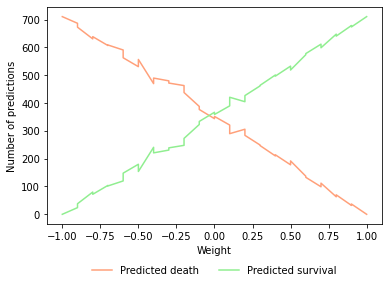

In [33]:
# Plot the distribution of predictions

# create a graph for the number of predicted deaths
deaths, = plt.plot(
    weights, # point at x-axis
    list(map(lambda cur: l_cm[cur][0][0] + l_cm[cur][1][0], steps)),
    "lightsalmon",  # color of the graph
    label="Predicted death"
)

# create a graph for the number of predicted survivals
survivals, = plt.plot(
    weights, # point at x-axis
    list(map(lambda cur: l_cm[cur][0][1] + l_cm[cur][1][1], steps)),
    "lightgreen",  # color of the graph
    label="Predicted survival"
)

plt.legend(handles=[deaths, survivals], loc="upper center", bbox_to_anchor=(0.5, -0.15), framealpha=0.0, ncol=2)
plt.xlabel("Weight")
plt.ylabel("Number of predictions")
plt.show()

In [ ]:
# Metrics of the hypocrite classifier

l_precision = list(map(
    lambda step: precision_score(train_labels, l_predictions[step]),
    steps
))

l_recall = list(map(
    lambda step: recall_score(train_labels, l_predictions[step]),
    steps
))

l_specificity = list(map(lambda step: specificity(l_cm[step]), steps))
l_npv = list(map(lambda step: npv(l_cm[step]), steps))

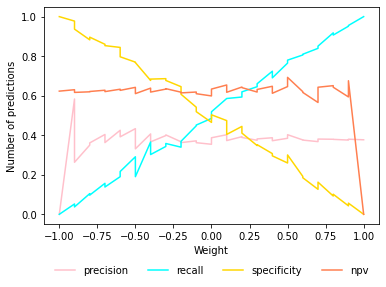

In [36]:
# Plot the performance measures
m_precision, = plt.plot(weights, l_precision, 'pink', label="precision")
m_recall, = plt.plot(weights, l_recall, 'cyan', label="recall")
m_specificity, = plt.plot(weights, l_specificity, 'gold', label="specificity")
m_npv, = plt.plot(weights, l_npv, 'coral', label="npv")

plt.legend(
    handles=[m_precision, m_recall, m_specificity, m_npv],
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    framealpha=0.0,
    ncol=4)

plt.xlabel("Weight")
plt.ylabel("Number of predictions")
plt.show()

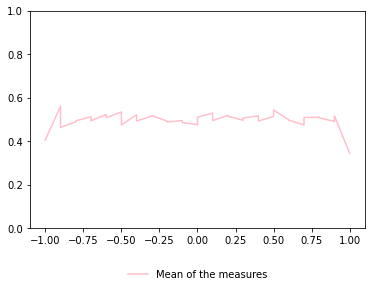

In [37]:
# Calculating the mean of the measures
l_mean = list(map(lambda step: sum(step) * 0.25, zip(l_precision, l_recall, l_specificity, l_npv)))

m_mean, = plt.plot(weights, l_mean, "pink", label="Mean of the measures")
plt.legend(handles=[m_mean],loc='upper center', bbox_to_anchor=(0.5, -0.15),framealpha=0.0)
plt.ylim(0, 1)
plt.show()

In [39]:
# A reusable function to unmask the hypocrite classifier
def classifier_report(name, run, classify, input, labels):
  cr_predictions = run(classify, input)
  cr_cm = confusion_matrix(labels, cr_predictions)

  cr_precision = precision_score(labels, cr_predictions)
  cr_recall = recall_score(labels, cr_predictions)
  cr_specificity = specificity(cr_cm)
  cr_npv = npv(cr_cm)
  cr_level = 0.25*(cr_precision + cr_recall + cr_specificity + cr_npv)

  print(f"The precision score of the {name} classifier is {cr_precision:.2f}")
  print(f"The recall score of the {name} classifier is {cr_recall:.2f}")
  print(f"The specificity score of the {name} classifier is {cr_specificity:.2f}")
  print(f"The npv score of the {name} classifier is {cr_npv:.2f}")
  print(f"The information level is: {cr_level:.2f}")

In [40]:
# The report of the random classifier
classifier_report("Random PQC", run, classify, train_input, train_labels)

The precision score of the Random PQC classifier is 0.38
The recall score of the Random PQC classifier is 0.53
The specificity score of the Random PQC classifier is 0.49
The npv score of the Random PQC classifier is 0.63
The information level is: 0.51
